In [2]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from fuzzywuzzy import fuzz
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Embedding, LSTM,Dropout,Bidirectional,GlobalMaxPooling1D

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# load dataset

In [4]:
data = pd.read_csv('Bot Dataset.csv')
pertanyaan = data['Question']
answer = data['Answer']

data.tail()


,tag,Question,Answer
153,user 154,Saya stres,Anda tahu mengambil terlalu banyak stres akan ...
154,user 155,Saya tidak akan pernah berhasil dalam hidup,Sukses adalah sesuatu yang dicapai pada waktu ...
155,user 156,p,"pa pe pa pe bae lu, salam kek"
156,user 157,Assalamualaikum,"Waalaikumsalam,dengan Neural disini,ada yg bis..."
157,user 158,Maukah kamu menjadi teman curhat saya?,"Tentu dengan senang hati,saya akan jadi teman ..."


# inisialisasi stop words

In [5]:
stopwords = []
with open('stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

In [6]:
# fungsi untuk menghilangkan stopwords
def remove_stopwords(text):
    text = text.lower()
    text = re.sub(r'[.,’"\'-?:!;]', '', text)
    text = re.sub(r'^Apa|^Saya', '', text)
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words)

In [7]:
# menghilangkan stopwords dari dataset
pertanyaanUser = pertanyaan.apply(remove_stopwords)
print(pertanyaanUser)

0                             penyakit mental
1                mempengaruhi penyakit mental
2                 menyebabkan penyakit mental
3      tanda tanda peringatan penyakit mental
4                 orang penyakit mental pulih
                        ...                  
153                                     stres
154                            berhasil hidup
155                                         p
156                           assalamualaikum
157                       maukah teman curhat
Name: Question, Length: 158, dtype: object


# inisialisasi tokenizer

In [8]:
# inisialisasi tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(pertanyaanUser)

In [9]:
# fungsi untuk mengganti kata typo dengan kata yang paling mirip pada dataset
def correct_typo(word):
    max_score = -1
    correct_word = word
    for vocab_word in tokenizer.word_index:
        score = fuzz.ratio(word, vocab_word)
        if score > max_score:
            max_score = score
            correct_word = vocab_word
    return correct_word

# fungsi untuk mengoreksi typo pada kalimat
def correct_sentence(sentence):
    corrected_sentence = []
    words = sentence.split()
    for word in words:
        corrected_word = correct_typo(word)
        corrected_sentence.append(corrected_word)
    return ' '.join(corrected_sentence)

# fungsi untuk membersihkan dan memproses input pengguna
def preprocess_input(text):
    text = remove_stopwords(text)
    text = correct_sentence(text)
    return text


# encoding label Respon

In [10]:
encoder = LabelEncoder()
encoder.fit(answer)
encoded_labels = encoder.transform(answer)

# split data menjadi train dan validation set

In [78]:
train_size = int(len(data) * 0.9)

train_data = data[:train_size]
val_data = data[train_size:]

train_seq = tokenizer.texts_to_sequences(train_data['Question'])
val_seq = tokenizer.texts_to_sequences(val_data['Question'])

train_label_seq = tokenizer.texts_to_sequences(train_data['Answer'])
val_label_seq = tokenizer.texts_to_sequences(val_data['Answer'])

#train_label_seq = encoded_labels[:train_size]
#val_label_seq = encoded_labels[train_size:]

# padding sequence

In [84]:
train_seq = pad_sequences(train_seq, maxlen=100, truncating='post')
val_seq = pad_sequences(val_seq, maxlen=100, truncating='post')

train_label_seq = pad_sequences(train_label_seq, maxlen=1000, truncating='post')
val_label_seq = pad_sequences(val_label_seq, maxlen=1000, truncating='post')

# callback

In [85]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.998:
            print("\n\nAccuracy Has Been Achieved Around 99.8%, Training Stop!\n")
            self.model.stop_training = True

# MODEL

In [86]:
model = Sequential([
    Embedding(len(tokenizer.word_index)+1, 16, input_length=100),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(159, activation='softmax')
])
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [87]:
# training model
history = model.fit(train_seq, train_label_seq, epochs=200,callbacks=[Callback()])

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 985, in launch_instance
      app.start()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_14300\4030300992.py", line 2, in <module>
      history = model.fit(train_seq, train_label_seq, epochs=200,callbacks=[Callback()])
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,159] and labels shape [32000]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_44771]

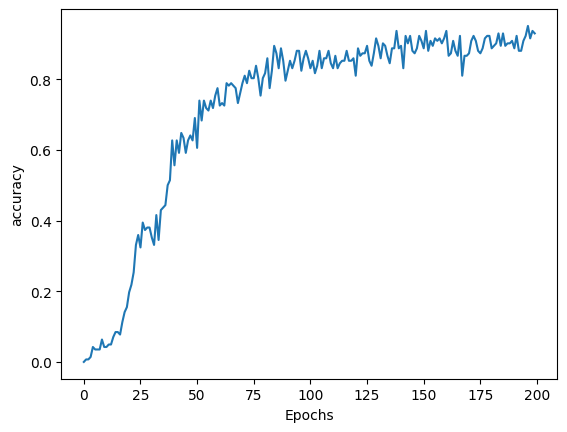

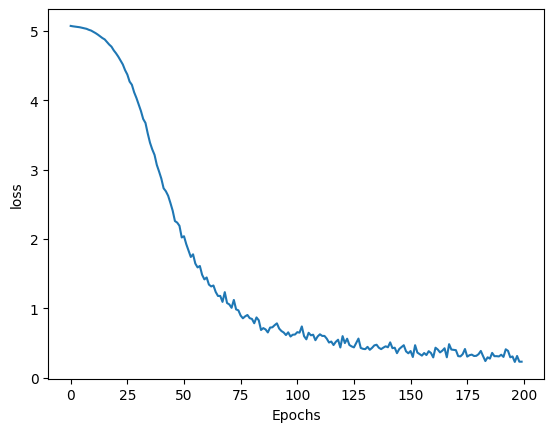

In [58]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")



# TESTING

In [70]:
try:
    input_text = input('Masukkan pertanyaan: ')
    preprocessed_text = preprocess_input(input_text)
    input_seq = tokenizer.texts_to_sequences([preprocessed_text])
    input_seq = pad_sequences(input_seq, maxlen=100)
    predicted_label_seq = model.predict(input_seq)
    predicted_label = encoder.inverse_transform(predicted_label_seq.argmax(axis=-1))
    print('Jawaban: ', predicted_label)
except:
    print("Bot : maaf saya tidak memahami maksud anda")

Masukkan pertanyaan: sayasedih
1/1 [==============================] - 0s 31ms/step
Jawaban:  ['Hei, bertahanlah. Aku tahu waktu itu sulit tapi bersabarlah dan semuanya akan jatuh pada tempatnya.  Ini adalah kutipan yang saya temukan yang dapat menghibur Anda "Lupakan yang hilang, hargai yang tersisa, dan nantikan yang akan datang".']


In [ ]:
input_text = input('Masukkan pertanyaan: ')
preprocessed_text = preprocess_input(input_text)
input_seq = tokenizer.texts_to_sequences([preprocessed_text])
input_seq = pad_sequences(input_seq, maxlen=100)
predicted_label_seq = model.predict(input_seq)
predicted_label = encoder.inverse_transform(predicted_label_seq.argmax(axis=-1))
print('Jawaban: ', predicted_label)
